In [139]:
# Audio preprocessing
import librosa
import soundfile as sf
import numpy as np
from pydub import AudioSegment
import seaborn as sns
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from hdbscan import approximate_predict

In [140]:
def load_audio(file_path, target_sr=16000):
    """
    Load a WAV audio file and resample it to a fixed sampling rate.
    
    Args:
        file_path (str): Path to the audio file.
        target_sr (int): Target sampling rate (default: 16kHz).
    
    Returns:
        y (numpy array): Audio waveform.
        sr (int): Sampling rate of the loaded audio.
    """
    y, sr = librosa.load(file_path, sr=target_sr)
    return y, sr

In [141]:
def rms_normalization(audio, target_rms=0.1):
    """
    Normalize the audio signal to a fixed RMS (Root Mean Square) value.

    Args:
        audio (numpy array): Input audio waveform.
        target_rms (float): Target RMS level.

    Returns:
        y_norm (numpy array): RMS-normalized audio waveform.
    """
    rms = np.sqrt(np.mean(audio**2))  # Compute current RMS
    scaling_factor = target_rms / (rms + 1e-10)  # Avoid division by zero
    y_norm = audio * scaling_factor  # Scale audio to match target RMS

    return y_norm

In [142]:
def calculate_features(audio_path):
    y, sr = load_audio(audio_path)  # Load and resample
    y_norm = rms_normalization(y)  # Normalize volume
    features = {}
    # --- 1. MFCCs ---
    mfccs = librosa.feature.mfcc(y=y_norm, sr=sr, n_mfcc=13)
    mfccs_mean = np.mean(mfccs, axis=1)
    features['mfccs'] = mfccs_mean
    
    # --- 2. Spectral Entropy ---
    spec = np.abs(librosa.stft(y_norm, n_fft=2048))
    col_sums = np.sum(spec, axis=0, keepdims=True)

    # Prevent division by zero
    col_sums[col_sums == 0] = 1e-10
    prob_dist = spec / col_sums

    entropy = -np.sum(prob_dist * np.log2(prob_dist + 1e-10), axis=0)
    features['spectral_entropy'] = np.mean(entropy)

    
    # --- 3. Zero-Crossing Rate ---
    zcr = librosa.feature.zero_crossing_rate(y_norm)
    features['zcr'] = np.mean(zcr)
    
    # --- 4. Spectral Centroid ---
    centroid = librosa.feature.spectral_centroid(y=y_norm, sr=sr)
    features['spectral_centroid'] = np.mean(centroid)
    
    # ✅ 5. Spectral Bandwidth
    spectral_bandwidth = librosa.feature.spectral_bandwidth(y=y_norm, sr=sr)
    bandwidth_mean = np.mean(spectral_bandwidth)
    features['spectral_bandwith'] = bandwidth_mean
    
     # Combine into a single feature vector
    feature_vector = np.concatenate([
        features['mfccs'],
        [features['spectral_entropy']],
        [features['zcr']],
        [features['spectral_centroid']],
        [features['spectral_bandwith']]
    ])
    return feature_vector

In [143]:
audios = [
    "splits/teacher1.wav",
    "splits/teacher2.wav",
    "splits/teacher3.wav",
    "splits/teacher4.wav",
    "splits/teacher5.wav",
    "splits/teacher6.wav",
    "splits/teacher7.wav",
    "splits/teacher8.wav",
    "splits/teacher9.wav",
    "splits/teacher10.wav",
]
X = [calculate_features(audio) for audio in audios]

In [144]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled

array([[-1.006491  , -0.50147258, -1.46932404,  0.75336248,  1.64554151,
        -0.22230088, -0.02107143, -0.02746118,  1.1904674 , -2.23994317,
        -0.59600345, -0.2381343 ,  1.22863925, -0.37039365, -0.13274694,
         0.04630491, -0.26772229],
       [-0.58443724,  1.08635409, -1.45555961, -1.19895759,  0.72297631,
        -1.13981611, -1.5127799 , -1.95795635,  0.92569167,  0.88900726,
        -0.70539343, -2.54708864, -1.34191501, -0.61388658, -0.38043304,
        -0.84624053, -1.17480429],
       [ 0.03282704,  0.13459442,  0.02375402, -1.29963568, -0.64672186,
         0.16611942,  0.23778778,  0.57275923, -2.25543839, -0.67106146,
        -1.1838341 ,  0.35164004,  0.55609854,  0.02848032, -0.31317345,
        -0.14249836,  0.20243049],
       [-0.04885218, -1.20724447,  1.7222787 ,  0.53919866, -1.18341899,
         0.17280381,  0.74916764,  0.97236165,  0.83721927, -0.65093957,
        -0.4620729 , -0.89227266, -1.31505754,  0.42664748,  1.01600412,
         1.14113365

In [145]:
import joblib
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

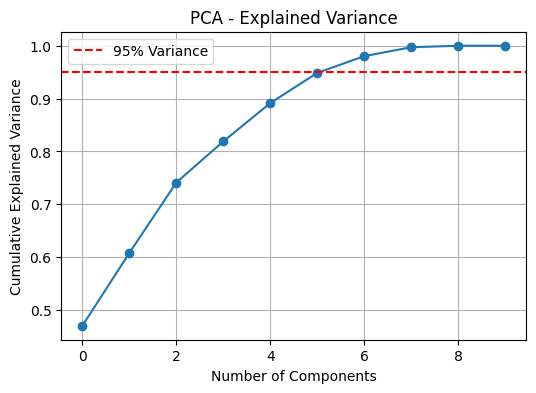

📉 Number of components to retain 95% variance: 7


In [146]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# Assume X_scaled is your scaled (standardized) 1024-dim embeddings
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Plot explained variance
plt.figure(figsize=(6, 4))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA - Explained Variance')
plt.grid(True)
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Variance')
plt.legend()
plt.show()

# Get number of components to retain 95% variance
n_components_95 = np.argmax(np.cumsum(pca.explained_variance_ratio_) >= 0.95) + 1
print(f"📉 Number of components to retain 95% variance: {n_components_95}")

In [147]:
from sklearn.decomposition import PCA
pca = PCA(n_components=7)
X_pca = pca.fit_transform(X_scaled)

In [148]:
joblib.dump(pca, 'pca_model.pkl')

['pca_model.pkl']

In [286]:
import hdbscan
from hdbscan import prediction

clusterer = hdbscan.HDBSCAN(min_cluster_size=2,min_samples=1,allow_single_cluster=True, prediction_data=True,cluster_selection_method='eom')
labels = clusterer.fit_predict(X_pca)
print(labels)

[-1 -1  0 -1  0  0  0  0  0 -1]


/home/web-h-054/Documents/signal_processing/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/web-h-054/Documents/signal_processing/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [287]:
def predict_and_check_outlier(audio_features, scaler, pca_model, clusterer, threshold=0.4):
    X_scaled = scaler.transform([audio_features])
    X_pca = pca_model.transform(X_scaled)
    
    label, strength = approximate_predict(clusterer, X_pca)
    label, strength = label[0], strength[0]

    is_outlier = strength < threshold
    return label, strength, is_outlier

In [288]:
new_features = calculate_features("splits/teacher2.wav")
label = predict_and_check_outlier(new_features,scaler,pca,clusterer)
label

(np.int32(0), np.float64(0.8277871772524594), np.False_)